In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install pycaret==3.3.2

In [2]:
import os
import sys
import json
import numpy   as np
import pandas  as pd
import pycaret as pc
from datetime import datetime
from typing   import Optional, List, Tuple
from pycaret.classification import *
from sklearn.preprocessing  import MultiLabelBinarizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows'   , 100)
print(
    f"""
    ┌ Pandas  🐼: V.{pd.__version__}
    ├ Numpy   🔢: V.{np.__version__}
    └ PyCaret 🧠: V.{pc.__version__}
    """
)


    ┌ Pandas  🐼: V.2.1.4
    ├ Numpy   🔢: V.1.26.4
    └ PyCaret 🧠: V.3.3.2
    


In [3]:
# 📌 Clase para la carga y preprocesamiento de datos
class DatasetProcessor:
    def __init__(self, filename: str = 'Copia de MLA_100k_checked_v3', test_size: int = 10000) -> None:
        self.filename  = filename
        self.test_size = test_size
        self.setup     = None
    # --------------------------------------------------------------------------
    def load_raw_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """LECTURA DEL DATAFRAME DESDE LOS DATOS BRUTOS .JSON"""
        try:
            N    = -self.test_size
            data = [json.loads(x) for x in open(self.filename)]
            Train = data[:N]
            Test  = data[N:]
            Train = pd.json_normalize(Train, sep = '_')
            Test  = pd.json_normalize(Test , sep = '_')
            return Train, Test
        except FileNotFoundError:
            raise ValueError(f"El archivo '{self.filename}' no fue encontrado.")
        except Exception as e:
            raise RuntimeError(f"Error al cargar el dataset: {e}")
    # --------------------------------------------------------------------------
    def count_list_fields(self, df: pd.DataFrame) -> pd.DataFrame:
        cols = ['non_mercado_pago_payment_methods', 'pictures']
        dict = {}
        for i in cols:
            dict[i] = df[i].apply(
                lambda x: np.nan if len(x) == 0 else len(x)
            )
        df_new = pd.DataFrame(data = dict)
        df_new.rename(
            columns = {
                'pictures': 'pictures_count',
                'non_mercado_pago_payment_methods': 'non_mercado_pago_payment_methods_count'
            },
            inplace = True
        )
        df_new['pictures_count'].fillna(0, inplace = True)
        df_new['non_mercado_pago_payment_methods_count'].fillna(0, inplace = True)
        return df_new
    # --------------------------------------------------------------------------
    def transform_datetime(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['date_created_dt'] = pd.to_datetime(df['date_created'])
        df['last_updated_dt'] = pd.to_datetime(df['last_updated'])

        df['age_days'] = (
                ( df['last_updated_dt'] - df['date_created_dt'] )
            ).apply(lambda x: x.total_seconds() / (60 * 60 * 24))
        df['duration_days'] = (
                ( df['stop_time'].apply(lambda x: datetime.fromtimestamp(x / 1000)) ) - \
                ( df['start_time'].apply(lambda x: datetime.fromtimestamp(x / 1000)) )
            ).apply(lambda x: x.total_seconds() / (60 * 60 * 24))
        return df[['date_created_dt', 'last_updated_dt', 'age_days', 'duration_days']]
    # --------------------------------------------------------------------------
    def list2text(self, df: pd.DataFrame, columns: list) -> pd.DataFrame:
        df = df.copy()
        for i in columns:
            if i in df.columns:
                df[i] = df[i].apply(lambda x: ', '.join(x) if isinstance(x, list) and x else 'NAN')
        return df
    # --------------------------------------------------------------------------
    def onehot_payments(self, df: pd.DataFrame, paymentsDict: dict) -> pd.DataFrame:
        paymentSeries = df['non_mercado_pago_payment_methods'].apply(
            lambda x: [d['description'] for d in x if isinstance(x, list) and 'description' in d]
        )
        MLB    = MultiLabelBinarizer(classes = sorted(paymentsDict))
        oneHot = MLB.fit_transform(paymentSeries)
        v_replace = np.vectorize(lambda x: x.replace(' ', '_').upper())
        return pd.DataFrame(oneHot, columns = v_replace(MLB.classes_), index = df.index)
    # --------------------------------------------------------------------------
    def cleaned_dataset(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        Train, Test = self.load_raw_data()
        NewCondition = {'used': 0, 'new': 1}
        Train['condition'] = Train['condition'].map(NewCondition)
        Test['condition']  = Test['condition'].map(NewCondition)

        paymentsDict = {
            'Acordar con el comprador', 'American Express', 'Cheque certificado'
            ,'Contra reembolso', 'Diners', 'Efectivo', 'Giro postal', 'MasterCard'
            , 'Mastercard Maestro', 'MercadoPago', 'Tarjeta de crédito', 'Transferencia bancaria'
            , 'Visa', 'Visa Electron'
        }
        Train = pd.concat([Train, self.count_list_fields(Train)] , axis = 1)
        Train = pd.concat([Train, self.transform_datetime(Train)], axis = 1)
        Train = pd.concat([Train, self.onehot_payments(Train, paymentsDict)], axis = 1)
        Test  = pd.concat([Test , self.count_list_fields(Test)]  , axis = 1)
        Test  = pd.concat([Test , self.transform_datetime(Test)] , axis = 1)
        Test  = pd.concat([Test , self.onehot_payments(Test, paymentsDict)], axis = 1)

        RemoveCols = [
            'attributes', 'category_id', 'coverage_areas', 'date_created', 'descriptions'
            , 'differential_pricing', 'international_delivery_mode', 'last_updated'
            , 'listing_source', 'non_mercado_pago_payment_methods', 'official_store_id'
            , 'original_price', 'parent_item_id', 'permalink', 'pictures', 'secure_thumbnail'
            , 'seller_address_city_id', 'seller_address_country_id', 'seller_address_country_name'
            , 'seller_address_state_id', 'shipping_dimensions', 'shipping_free_methods'
            , 'shipping_methods', 'shipping_tags', 'shipping_tagscatalog_product_id', 'site_id'
            , 'start_time', 'stop_time', 'subtitle', 'thumbnail', 'variations', 'video_id', 'warranty'
        ]
        Train.drop(RemoveCols, axis = 1, errors = 'ignore', inplace = True)
        Test.drop(RemoveCols , axis = 1, errors = 'ignore', inplace = True)

        GetTextCols = ['deal_ids', 'sub_status', 'tags']
        Train = self.list2text(Train, GetTextCols)
        Test  = self.list2text(Test , GetTextCols)

        Train.set_index('id', inplace = True); Test.set_index('id', inplace = True)
        SCHEMA = {
            'accepts_mercadopago'                     : 'bool'
            , 'automatic_relist'                      : 'int64'
            , 'available_quantity'                    : 'int64'
            , 'base_price'                            : 'float64'
            , 'buying_mode'                           : 'str'
            , 'catalog_product_id'                    : 'str'
            , 'condition'                             : 'bool'
            , 'currency_id'                           : 'str'
            , 'deal_ids'                              : 'str'
            , 'duration_days'                         : 'float64'
            , 'initial_quantity'                      : 'int64'
            , 'listing_type_id'                       : 'str'
            , 'non_mercado_pago_payment_methods_count': 'int64'
            , 'pictures_count'                        : 'int64'
            , 'price'                                 : 'float64'
            , 'seller_address_city_name'              : 'str'
            , 'seller_address_state_name'             : 'str'
            , 'seller_id'                             : 'float64'
            , 'shipping_free_shipping'                : 'int64'
            , 'shipping_local_pick_up'                : 'int64'
            , 'shipping_mode'                         : 'str'
            , 'sold_quantity'                         : 'int64'
            , 'status'                                : 'str'
            , 'sub_status'                            : 'str'
            , 'tags'                                  : 'str'
            , 'title'                                 : 'str'
            , 'ACORDAR_CON_EL_COMPRADOR'              : 'bool'
            , 'AMERICAN_EXPRESS'                      : 'bool'
            , 'CHEQUE_CERTIFICADO'                    : 'bool'
            , 'CONTRA_REEMBOLSO'                      : 'bool'
            , 'DINERS'                                : 'bool'
            , 'EFECTIVO'                              : 'bool'
            , 'GIRO_POSTAL'                           : 'bool'
            , 'MASTERCARD'                            : 'bool'
            , 'MASTERCARD_MAESTRO'                    : 'bool'
            , 'MERCADOPAGO'                           : 'bool'
            , 'TARJETA_DE_CRÉDITO'                    : 'bool'
            , 'TRANSFERENCIA_BANCARIA'                : 'bool'
            , 'VISA'                                  : 'bool'
            , 'VISA_ELECTRON'                         : 'bool'
        }
        Train = Train.astype(SCHEMA); Test = Test.astype(SCHEMA)

        Train = Train.applymap(lambda x: x.upper() if type(x) == str else x)
        Test  = Test.applymap(lambda x: x.upper() if type(x) == str else x)
        # Train.drop('condition', axis = 1), Train[['condition']], Test.drop('condition', axis = 1), Test[['condition']]
        return Train, Test

# 📌 Clase para el modelo de clasificación binaria
class BinaryClassifier:
    def __init__(self, **kwargs) -> None:
        self.params = kwargs

    def setup_training_pipeline(self, X_train: pd.DataFrame, X_test: pd.DataFrame, target: str) -> None:
        return setup(data = X_train, target = 'condition', test_data = X_test, **self.params)

    def save_transformed(self, path: str) -> None:
        Data_transformed = get_config('dataset_transformed')
        X_train_transformed = get_config('X_train_transformed'); y_train = get_config('y_train')
        X_test_transformed  = get_config('X_test_transformed') ; y_test  = get_config('y_test')

        Data_transformed.to_parquet(path + 'Data_transformed.parquet.gzip', compression = 'brotli')
        X_train_transformed.to_parquet(path + 'X_train_transformed.parquet.gzip', compression = 'brotli')
        X_test_transformed.to_parquet(path  + 'X_test_transformed.parquet.gzip' , compression = 'brotli')
        y_train.to_frame().to_parquet(path + 'y_train.parquet.gzip', compression = 'brotli')
        y_test.to_frame().to_parquet(path  + 'y_test.parquet.gzip' , compression = 'brotli')
        return None

In [4]:
Builder = DatasetProcessor('/lakehouse/default/Files/Copia de MLA_100k_checked_v3.jsonlines')
X_train, X_test = Builder.cleaned_dataset()

# Setup ➡️ Create Model ➡️ Assign Labels ➡️ Analyze Model ➡️ Prediction ➡️ Save Model
catVars = [
    'buying_mode', 'catalog_product_id', 'currency_id', 'deal_ids', 'listing_type_id'
    , 'seller_address_city_name', 'seller_address_state_name', 'shipping_mode'
    , 'status', 'sub_status', 'tags', 'title'
    , 'ACORDAR_CON_EL_COMPRADOR', 'AMERICAN_EXPRESS', 'CHEQUE_CERTIFICADO', 'CONTRA_REEMBOLSO'
    , 'DINERS', 'EFECTIVO', 'GIRO_POSTAL', 'MASTERCARD', 'MASTERCARD_MAESTRO', 'MERCADOPAGO'
    , 'TARJETA_DE_CRÉDITO', 'TRANSFERENCIA_BANCARIA', 'VISA', 'VISA_ELECTRON'
]
numVars = [
    'age_days', 'automatic_relist', 'available_quantity', 'base_price', 'duration_days'
    , 'initial_quantity', 'non_mercado_pago_payment_methods_count', 'pictures_count'
    , 'price', 'seller_id', 'shipping_free_shipping', 'shipping_local_pick_up', 'sold_quantity'
]
# ------------------------------------------------------------------------------
Classifier = BinaryClassifier(
    # , ordinal_features = None, numeric_features = numVars, categorical_features = catVars
    date_features = ['date_created_dt', 'last_updated_dt'], create_date_columns = ['day', 'month', 'year']
    , imputation_type = 'simple', iterative_imputation_iters = 10
    , numeric_imputation = 0, categorical_imputation = 'mode'
    , max_encoding_ohe = 200, fix_imbalance = False, fix_imbalance_method = 'SMOTE'
    , normalize = True, normalize_method = 'minmax'                       # zscore | maxabs | robust
    , fold = 20, fold_strategy = 'stratifiedkfold', fold_shuffle = False  # kfold  | groupkfold
    , n_jobs = -1, use_gpu = False, session_id = 2025
    # , log_experiment = 'mlflow', experiment_name = 'MercadoLibre_BinaryClass'
)
Classifier.setup_training_pipeline(X_train, X_test, 'condition')

,Description,Value
0,Session id,2025
1,Target,condition
2,Target type,Binary
3,Original data shape,"(100000, 43)"
4,Transformed data shape,"(100000, 132)"
5,Transformed train set shape,"(90000, 132)"
6,Transformed test set shape,"(10000, 132)"
7,Numeric features,13
8,Date features,2
9,Categorical features,12


In [5]:
# Obtiene las variables de entorno para configuraciones accesibles.
print(get_config())

{'pipeline', 'dataset', 'fold_groups_param', 'exp_name_log', 'target_param', 'test', 'X_test', 'idx', 'train', 'data', 'y_train_transformed', '_ml_usecase', 'y_transformed', 'variables', 'X_train', 'gpu_param', 'is_multiclass', 'X_train_transformed', 'test_transformed', 'exp_id', 'X_transformed', 'y', 'gpu_n_jobs_param', 'n_jobs_param', '_available_plots', 'html_param', 'X', 'fold_shuffle_param', 'seed', 'y_test_transformed', 'y_train', 'memory', 'log_plots_param', 'USI', 'fix_imbalance', 'fold_generator', 'variable_and_property_keys', 'dataset_transformed', 'train_transformed', 'logging_param', 'y_test', 'X_test_transformed'}


In [6]:
# Muestra gráficamente el pipeline de la ETL y clasificación.
get_config('pipeline')

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None,
                                    include=['date_created_dt',
                                             'last_updated_dt'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['base_price', 'seller_id', 'price',
                                             'automatic_relist',
                                             'init...
                                                              hierarchy=None,
                                                              min_samples_leaf=20,
                                                              return_df=True,
                                                              smoothing=10,
                                                              verbose=0))),
                ('normalize',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=MinMaxScaler(clip=False,
                                                             copy=True,
                                                             feature_range=(0,
                                                                            1)))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [7]:
# Lista los modelos disponibles en PyCaret para probar en clasificación.
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [8]:
# Devuelve la lista de métricas de clasificación disponibles (Precisión, Recall, F1, ROC-AUC).
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x75975236e700>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x75975236dd00>,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x75975236c900>,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False


In [9]:
# Lista los gráficos disponibles para visualización en clasificación binaria.
get_config('_available_plots')

{'pipeline': 'Pipeline Plot',
 'parameter': 'Hyperparameters',
 'auc': 'AUC',
 'confusion_matrix': 'Confusion Matrix',
 'threshold': 'Threshold',
 'pr': 'Precision Recall',
 'error': 'Prediction Error',
 'class_report': 'Class Report',
 'rfe': 'Feature Selection',
 'learning': 'Learning Curve',
 'manifold': 'Manifold Learning',
 'calibration': 'Calibration Curve',
 'vc': 'Validation Curve',
 'dimension': 'Dimensions',
 'feature': 'Feature Importance',
 'feature_all': 'Feature Importance (All)',
 'boundary': 'Decision Boundary',
 'lift': 'Lift Chart',
 'gain': 'Gain Chart',
 'tree': 'Decision Tree',
 'ks': 'KS Statistic Plot'}

In [10]:
# Guarda el DataFrame transformado en formato Parquet para su uso en otros modelos y librerías.
os.chdir('/lakehouse/default/Files')
print(f'Current Working Directory: {os.getcwd()}')

Classifier.save_transformed(path = '')

Current Working Directory: /lakehouse/default/Files


In [11]:
# Entrena y evalúa todos los estimadores disponibles mediante validación cruzada.
#   Retorna una tabla con los puntajes promedio de CV.
Top3_Models = compare_models(
    include = ['lr', 'knn', 'dt', 'rf', 'et', 'xgboost', 'lightgbm', 'svm', 'ridge', 'gbc']
    , cross_validation = True, sort = 'Accuracy', n_select = 3, probability_threshold = 0.5
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8089,0.8770,0.8512,0.8045,0.8272,0.6139,0.6151,2.2290
et,Extra Trees Classifier,0.7759,0.8819,0.9380,0.7257,0.8182,0.5385,0.5695,2.9970
lr,Logistic Regression,0.7604,0.8677,0.9513,0.7054,0.8101,0.5041,0.5469,1.2840
rf,Random Forest Classifier,0.7265,0.8951,0.9672,0.6702,0.7917,0.4297,0.4951,2.2260
xgboost,Extreme Gradient Boosting,0.7169,0.7660,0.8221,0.7022,0.7572,0.4228,0.4309,1.4210
gbc,Gradient Boosting Classifier,0.7130,0.7742,0.9301,0.6677,0.7769,0.4038,0.4515,5.9860
lightgbm,Light Gradient Boosting Machine,0.7026,0.7525,0.8258,0.6854,0.7489,0.3918,0.4028,2.3230
ridge,Ridge Classifier,0.6929,0.8280,0.9565,0.6443,0.7699,0.3572,0.4261,0.9015
dt,Decision Tree Classifier,0.6841,0.6676,0.8332,0.6638,0.7380,0.3516,0.3695,0.8765
svm,SVM - Linear Kernel,0.6162,0.7786,0.9324,0.6069,0.7221,0.1865,0.2427,0.8905


────────────────────────────────────────────────────────────────────────────────
Model: KNeighborsClassifier


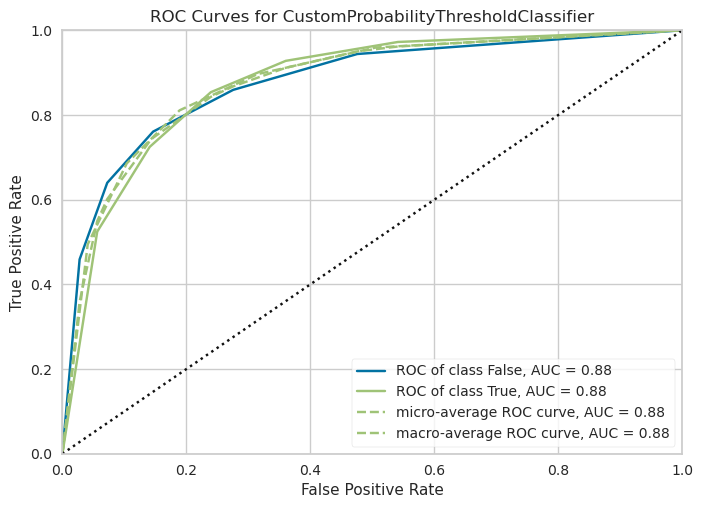

────────────────────────────────────────────────────────────────────────────────
Model: ExtraTreesClassifier


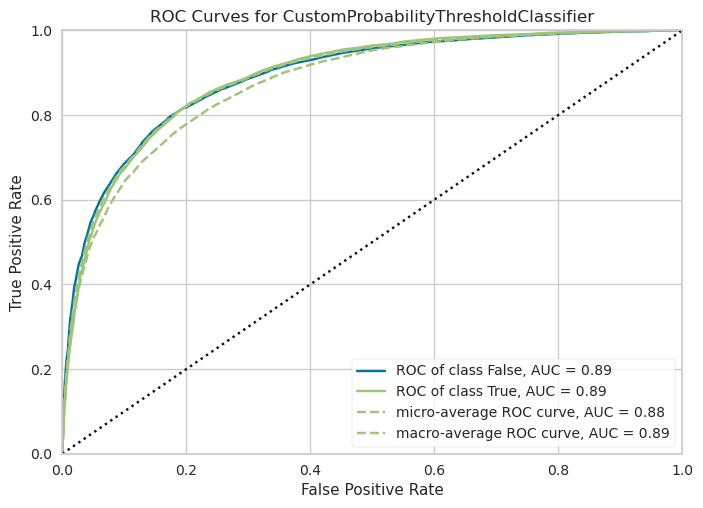

────────────────────────────────────────────────────────────────────────────────
Model: LogisticRegression


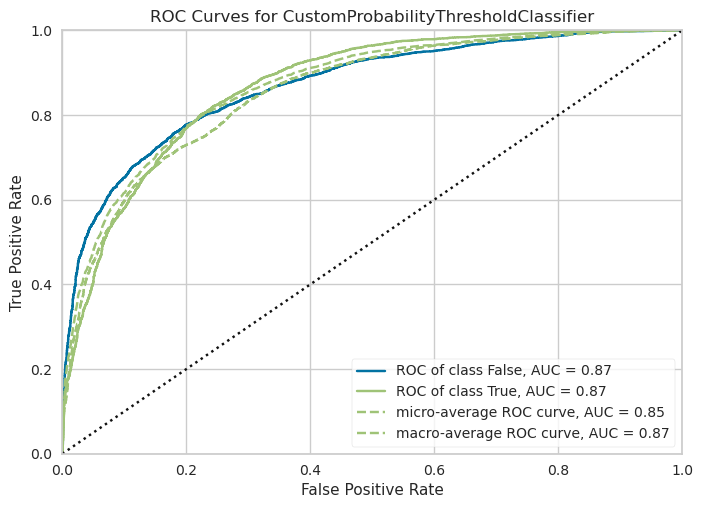

────────────────────────────────────────────────────────────────────────────────
Model: KNeighborsClassifier


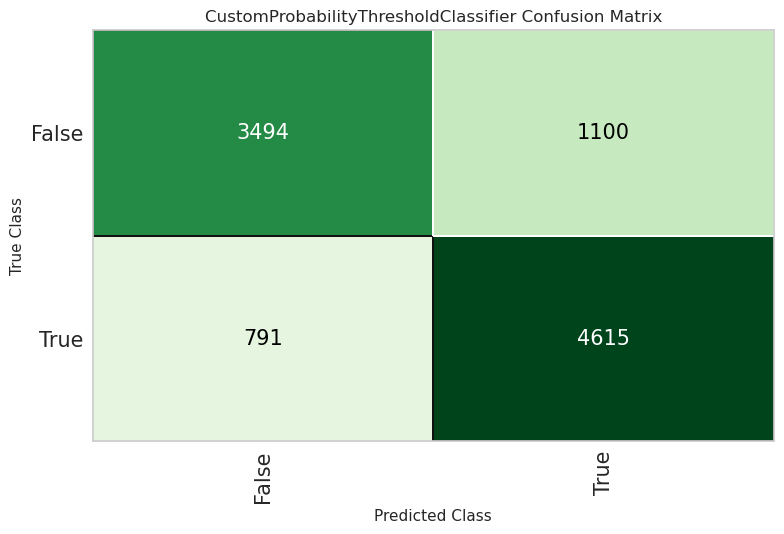

────────────────────────────────────────────────────────────────────────────────
Model: ExtraTreesClassifier


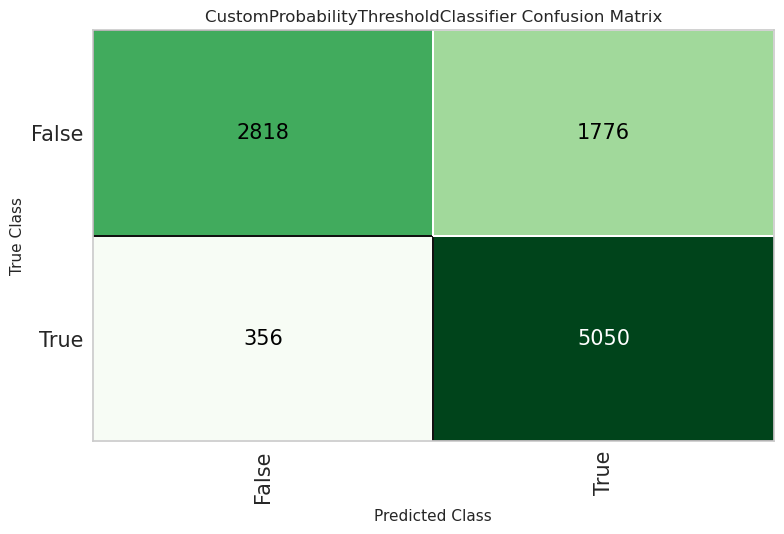

────────────────────────────────────────────────────────────────────────────────
Model: LogisticRegression


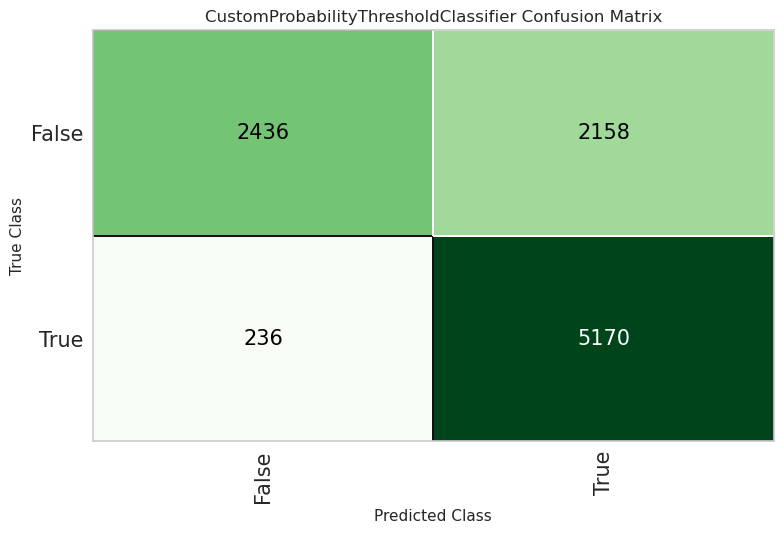

In [12]:
# Grafica la curva AUC y la matriz de confusión de los mejores modelos para compararlos con los resultados finales.
for i in Top3_Models: print('─'*80 + f"\nModel: {type(i.classifier_).__name__}"); plot_model(i, 'auc')
for i in Top3_Models: print('─'*80 + f"\nModel: {type(i.classifier_).__name__}"); plot_model(i, 'confusion_matrix')

In [13]:
# Tuned_Top3_Models = [
#     tune_model(estimator = i, fold = 2, n_iter = 10, optimize = 'Accuracy', choose_better = True) for i in Top3_Models
# ]
Blender_Weighted = blend_models(
    estimator_list = Top3_Models, choose_better = True, optimize = 'Accuracy', method = 'auto', weights = [0.5, 0.3, 0.2]
)
Blender_Weighted_Results = pull()
Blender_Weighted_Results

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8196,0.9015,0.8900,0.7976,0.8413,0.6337,0.6388
1,0.8211,0.9004,0.8916,0.7988,0.8427,0.6368,0.6420
2,0.8162,0.8997,0.8883,0.7941,0.8386,0.6268,0.6321
3,0.8182,0.8956,0.8991,0.7911,0.8417,0.6303,0.6375
4,0.8233,0.8986,0.8933,0.8009,0.8446,0.6413,0.6465
5,0.8169,0.9021,0.8987,0.7896,0.8406,0.6276,0.6348
6,0.8167,0.9010,0.8978,0.7897,0.8403,0.6272,0.6343
7,0.8289,0.9073,0.9032,0.8029,0.8501,0.6524,0.6585
8,0.8104,0.8950,0.8900,0.7857,0.8346,0.6146,0.6212


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8196,0.9015,0.8900,0.7976,0.8413,0.6337,0.6388
1,0.8211,0.9004,0.8916,0.7988,0.8427,0.6368,0.6420
2,0.8162,0.8997,0.8883,0.7941,0.8386,0.6268,0.6321
3,0.8182,0.8956,0.8991,0.7911,0.8417,0.6303,0.6375
4,0.8233,0.8986,0.8933,0.8009,0.8446,0.6413,0.6465
5,0.8169,0.9021,0.8987,0.7896,0.8406,0.6276,0.6348
6,0.8167,0.9010,0.8978,0.7897,0.8403,0.6272,0.6343
7,0.8289,0.9073,0.9032,0.8029,0.8501,0.6524,0.6585
8,0.8104,0.8950,0.8900,0.7857,0.8346,0.6146,0.6212


In [14]:
Blender_Weighted

VotingClassifier(estimators=[('K Neighbors Classifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('Extra Trees Classifier',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='sqrt',
                                                   max_leaf_nodes=...
                                                   warm_start=False)),
                             ('Logistic Regression',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=2025,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0,
                                                 warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=[0.5, 0.3, 0.2])

In [15]:
print('─'*80 + f"\n{type(Blender_Weighted)}"); print('─'*80 + f"\n{Blender_Weighted}"); print('─'*80 + f"\n{Blender_Weighted.estimators_}")
# Stacker = stack_models(estimator_list = Tuned_Top3_Models, method = 'auto', optimize = 'Accuracy', fold = 5, meta_model = LogisticRegression)
# print(type(Stacker)); print(Stacker); print(Stacker.estimators_)
# evaluate_model(Stacker)
# Best_Accuracy_Model = automl(optimize = 'Accuracy')
# Best_Accuracy_Model

────────────────────────────────────────────────────────────────────────────────
<class 'sklearn.ensemble._voting.VotingClassifier'>
────────────────────────────────────────────────────────────────────────────────
VotingClassifier(estimators=[('K Neighbors Classifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('Extra Trees Classifier',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                        

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8115,0.8943,0.8711,0.7970,0.8324,0.6180,0.6212
1,0.8135,0.8931,0.8809,0.7943,0.8354,0.6216,0.6260
2,0.8117,0.8929,0.8798,0.7926,0.8339,0.6180,0.6225
Mean,0.8122,0.8934,0.8773,0.7946,0.8339,0.6192,0.6232
Std,0.0009,0.0006,0.0044,0.0018,0.0012,0.0017,0.0020


Fitting 3 folds for each of 7 candidates, totalling 21 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the followin

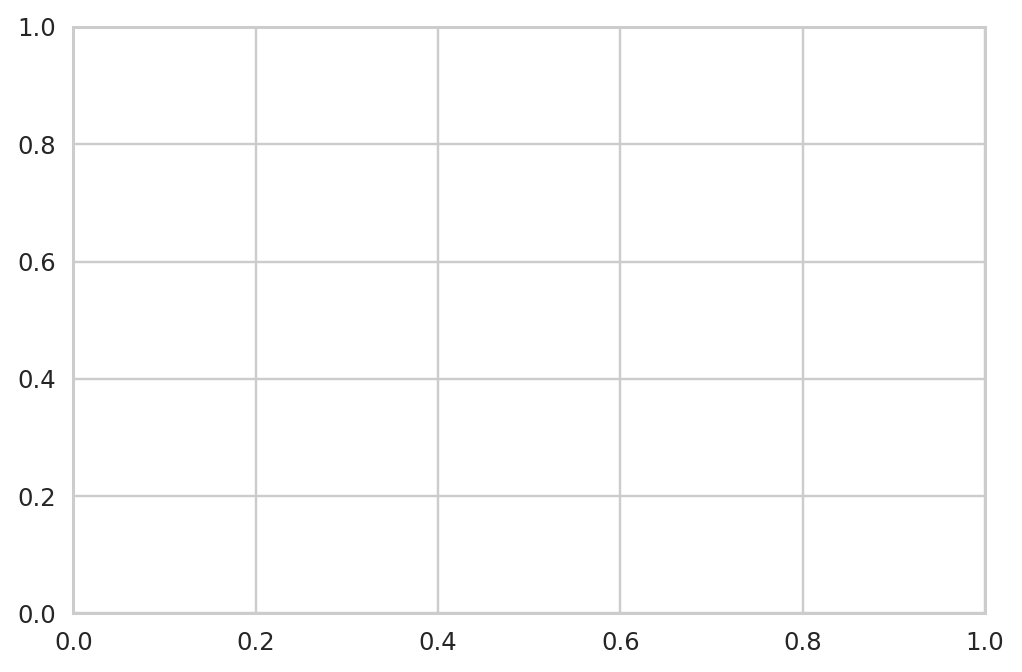

In [16]:
Tuned_Blender_Weighted = tune_model(estimator = Blender_Weighted, fold = 3, n_iter = 7, optimize = 'Accuracy', choose_better = True)

In [17]:
Tuned_Blender_Weighted

VotingClassifier(estimators=[('K Neighbors Classifier',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=5,
                                                   p=2, weights='uniform')),
                             ('Extra Trees Classifier',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='sqrt',
                                                   max_leaf_nodes=...
                                                   warm_start=False)),
                             ('Logistic Regression',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=2025,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0,
                                                 warm_start=False))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=[0.5, 0.3, 0.2])

StatementMeta(, acf92bb0-177d-49ff-b9e2-c538be6445a5, 24, Finished, Available, Finished)

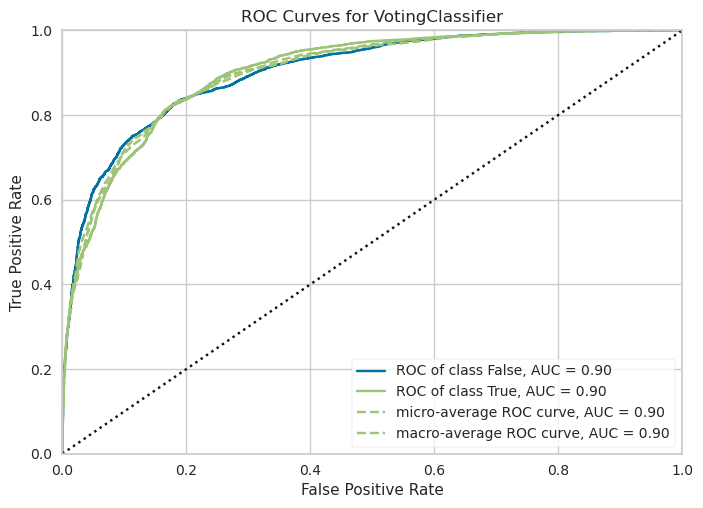

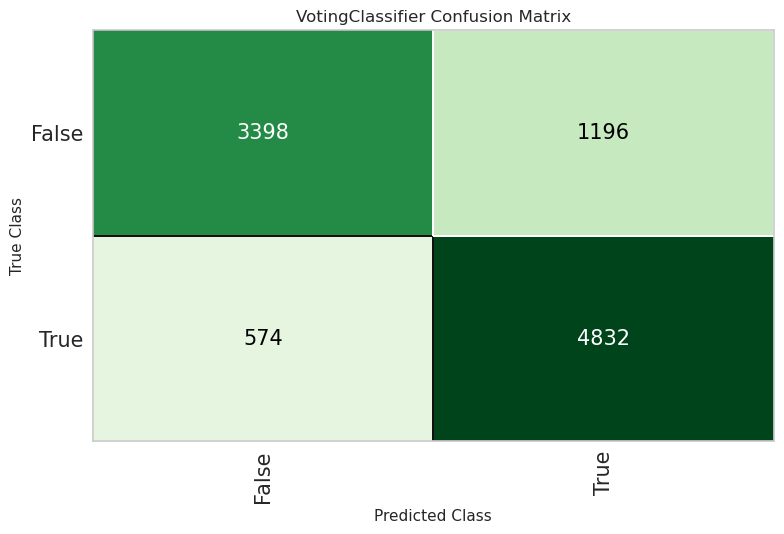

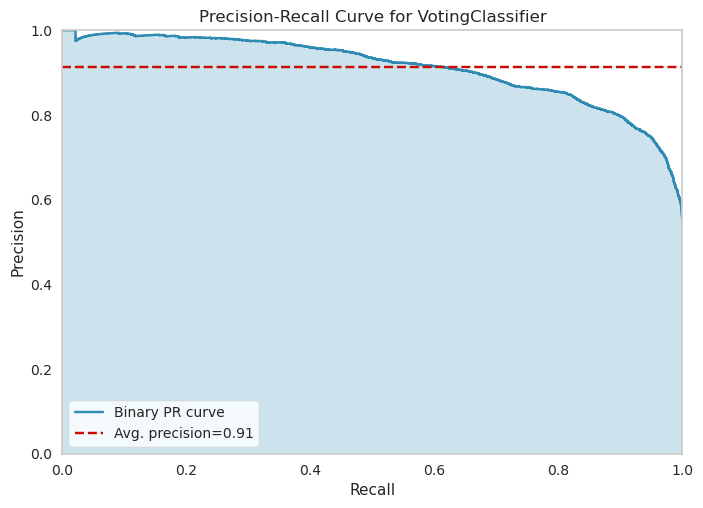

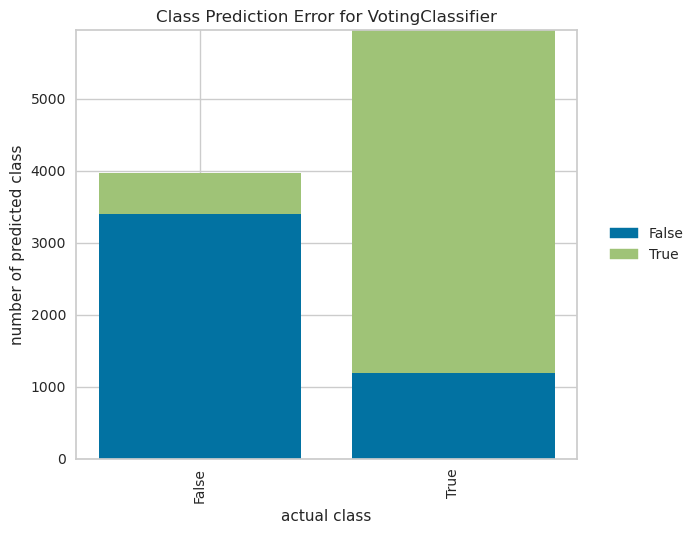

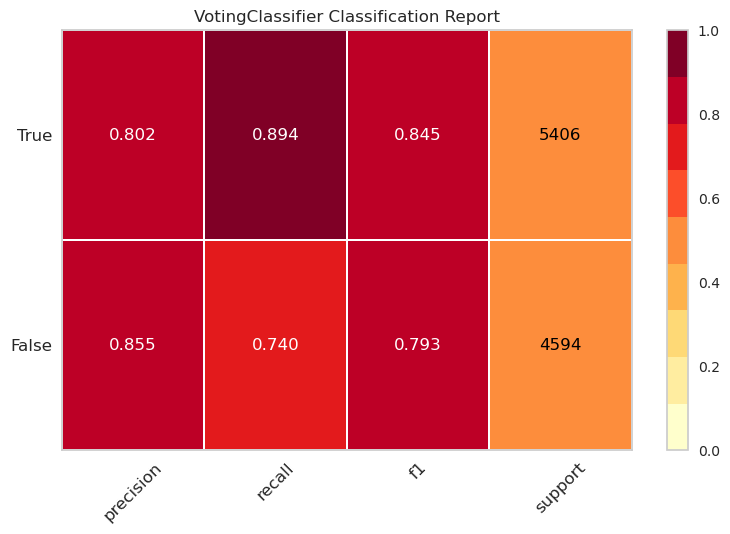

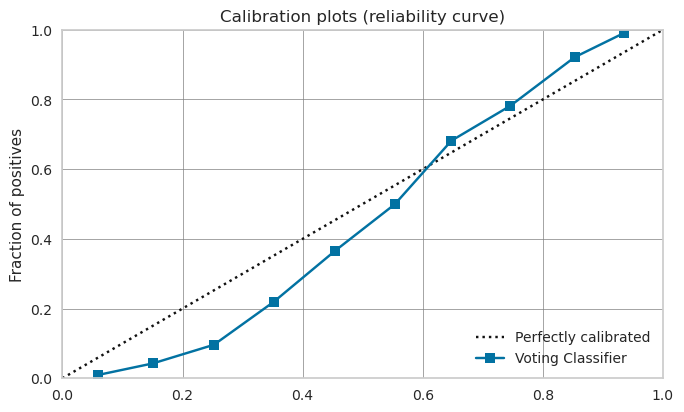

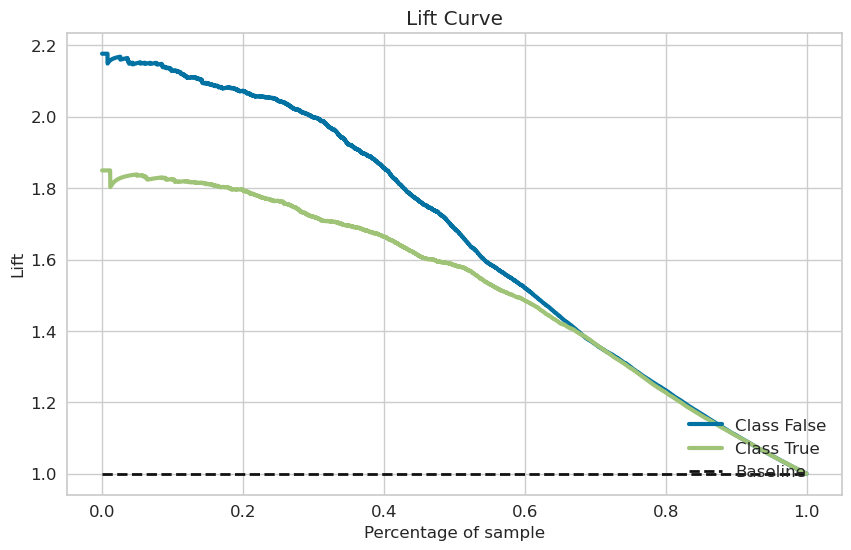

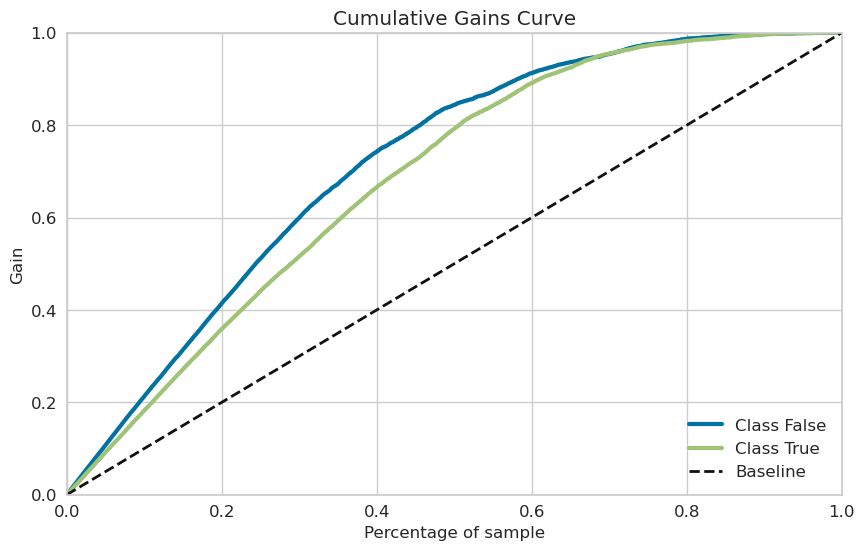

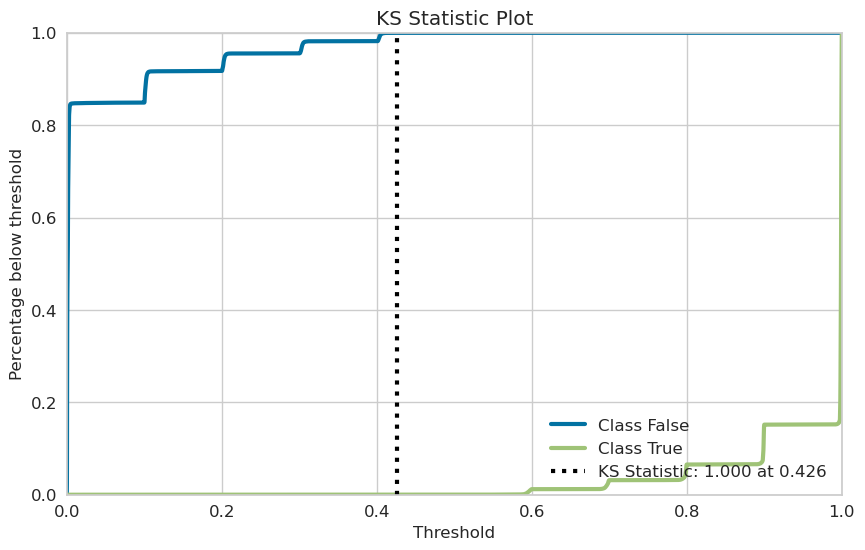

In [21]:
plot_model(Tuned_Blender_Weighted, plot = 'auc')
plot_model(Tuned_Blender_Weighted, plot = 'confusion_matrix')
plot_model(Tuned_Blender_Weighted, plot = 'pr')
plot_model(Tuned_Blender_Weighted, plot = 'error')
plot_model(Tuned_Blender_Weighted, plot = 'class_report')
plot_model(Tuned_Blender_Weighted, plot = 'calibration')
plot_model(Tuned_Blender_Weighted, plot = 'lift')
plot_model(Tuned_Blender_Weighted, plot = 'gain')
plot_model(Tuned_Blender_Weighted, plot = 'ks')

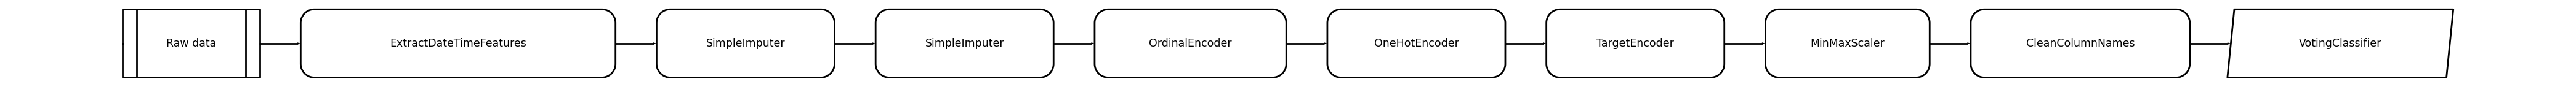

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

StatementMeta(, acf92bb0-177d-49ff-b9e2-c538be6445a5, 23, Finished, Available, Finished)

No such comm: 0ac41d3068b941bc8d918601869a69c1
No such comm: 0d27b1394bc84b47a49dea615a460abe
No such comm: 02aba180e9f748438688792591f8f434


In [18]:
evaluate_model(Tuned_Blender_Weighted)

In [19]:
ModelFinal = finalize_model(Tuned_Blender_Weighted)
ModelFinal

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None,
                                    include=['date_created_dt',
                                             'last_updated_dt'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['base_price', 'seller_id', 'price',
                                             'automatic_relist',
                                             'initial_quantit...
                                              ('Logistic Regression',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                                                                  max_iter=1000,
                                                                  multi_class='auto',
                                                                  n_jobs=None,
                                                                  penalty='l2',
                                                                  random_state=2025,
                                                                  solver='lbfgs',
                                                                  tol=0.0001,
                                                                  verbose=0,
                                                                  warm_start=False))],
                                  flatten_transform=True, n_jobs=-1,
                                  verbose=False, voting='soft',
                                  weights=[0.5, 0.3, 0.2]))],
         verbose=False)

In [20]:
save_model(ModelFinal, 'Final_Model_MercadoLibre')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None,
                                     include=['date_created_dt',
                                              'last_updated_dt'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['base_price', 'seller_id', 'price',
                                              'automatic_relist',
                                              'initial_quantit...
                                               ('Logistic Regression',
                                                LogisticRegression(C=1.0,
        